In [2]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.1


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
import torch_geometric
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import networkx as nx
import time
from datetime import datetime
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data, DataLoader
import torch.optim as optim
import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE

import sklearn.metrics as metrics 

import matplotlib.pyplot as plt

In [4]:
# Define a function to pad or truncate the vectors to a fixed length
def pad_or_truncate_vector(vector, length):
    if len(vector) < length:
        return vector + [0] * (length - len(vector))
    elif len(vector) > length:
        return vector[:length]
    else:
        return vector

In [21]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.input_dim = input_dim
        self.output_dim = output_dim

    def encode(self, x):
        # Encode the input
        hidden = self.encoder(x)
        mean, log_var = torch.chunk(hidden, 2, dim=-1)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        # Decode the latent variable
        decoded = self.decoder(z)
        return decoded

    def forward(self, x, mask=None):
        # Forward pass through the VAE
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        decoded = self.decode(z)

        # Apply mask to ignore padded zeros
        if mask is not None:
            decoded = decoded * mask.unsqueeze(2)  # Multiply by the mask

        return decoded, mean, log_var

In [22]:
class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(AE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.input_dim = input_dim
        self.output_dim = output_dim

    def encode(self, x):
        # Encode the input
        hidden = self.encoder(x)
        return hidden

    def decode(self, z):
        # Decode the latent variable
        decoded = self.decoder(z)
        return decoded

    def forward(self, x, mask=None):
        # Forward pass through the autoencoder
        encoded = self.encode(x)
        decoded = self.decode(encoded)

        # Apply mask to ignore padded zeros
        if mask is not None:
            decoded = decoded * mask.unsqueeze(2)  # Multiply by the mask

        return decoded

In [5]:
import torch
import torch.nn as nn

class AEL(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super(AEL, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.2),  # Adding LeakyReLU activation function
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2),  # Adding LeakyReLU activation function
            nn.Linear(hidden_dim2, latent_dim)
        )

        self.input_dim = input_dim
        self.latent_dim = latent_dim

    def encode(self, x):
        # Encode the input
        hidden = self.encoder(x)
        return hidden

    def forward(self, x, mask=None):
        # Forward pass through the autoencoder
        encoded = self.encode(x)
        # Apply mask to ignore padded zeros
        if mask is not None:
            encoded = encoded * mask.unsqueeze(2)  # Multiply by the mask
        return encoded

In [6]:
def split_and_convert(value):
    if pd.isna(value) or not isinstance(value, str):
        return []
    else:
        # Split the string and convert each element to float if possible
        values = value.split('|')
        numeric_values = []
        for val in values:
            try:
                numeric_val = float(val)
                numeric_values.append(numeric_val)
            except ValueError:
                pass  # Skip non-numeric values
        return numeric_values

In [7]:
#READ DATA

LOC   = "/Users/arthurdai/Desktop/Fighting/TCGA_integrative"
CANCER = "BLCA"
PPI   = f'{LOC}/{CANCER}/{CANCER}_PPI.csv'
GS = f'{LOC}/{CANCER}/{CANCER}_GS.csv'
ID = f'{LOC}/{CANCER}/{CANCER}_ID.csv'
Cluster = f'{LOC}/{CANCER}/{CANCER}_im_cluster.csv'
HRD = f'{LOC}/{CANCER}/{CANCER}_hrd.csv'
Stem = f'{LOC}/{CANCER}/{CANCER}_stem.csv'
FEATURES = [f'{LOC}/{CANCER}/{CANCER}_EXP.csv', f'{LOC}/{CANCER}/{CANCER}_CNV.csv',
f'{LOC}/{CANCER}/{CANCER}_MUT.csv', f'{LOC}/{CANCER}/{CANCER}_cpgisland.csv', f'{LOC}/{CANCER}/{CANCER}_non_cpgisland.csv',
f'{LOC}/{CANCER}/{CANCER}_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_non_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_enhancer.csv']

#scaler = StandardScaler()

#Import multi-omics files
gs = pd.read_csv(GS, index_col=0)
#node = pd.read_csv(Node, index_col=0)
exp = pd.read_csv(FEATURES[0], index_col=0).reindex(gs.index)
id = pd.read_csv(ID, index_col=1)

Cluster = pd.read_csv(Cluster, index_col=0).reindex(id.index).Cluster
HRD = pd.read_csv(HRD, index_col=0).reindex(id.index).HRD_group
Stem = pd.read_csv(Stem, index_col=0).reindex(id.index).RNAss_group

feats = []

for path in FEATURES:
      feat_df = pd.read_csv(path, index_col=0) 
      feat_df = feat_df.reindex(gs.index, fill_value=0)
      feat_df = feat_df.transpose()
      feats.append(feat_df)

#For feature 2-4
for i in range(1,3):
    feat_df = feats[i].reindex(id.index, fill_value=0)
    feats[i] = feat_df

#For feature 5-9
for i in range(3,8):
    feat_df = feats[i].reindex(id.index, fill_value=0)
    #Create list
    new_df = feat_df.applymap(split_and_convert)
    
    ls = new_df.values.tolist()
    
    for row in ls:
      lengths = [len(subset) for subset in row]
      max_length = max(lengths)
      
      # Create the VAE model
      input_dim = max_length  # Dimension of the output vector
      hidden_dim = 64  # Hidden layer dimension
      latent_dim = 16  # Latent variable dimension
      output_dim = 1
      #vae = VAE(input_dim, hidden_dim, latent_dim, output_dim)
      #ae = AE(input_dim, hidden_dim, latent_dim, output_dim)
      ael = AEL(input_dim, hidden_dim1=64, hidden_dim2=32, latent_dim=1)
    
    #Use VAE to ouput feature values
    with torch.no_grad():
        x_padded = []
        for row in new_df.values.tolist():
            padded_row = [pad_or_truncate_vector(vector, max_length) for vector in row]
            x_padded.append(padded_row)
        x = torch.tensor(x_padded, dtype=torch.float)
        torch.manual_seed(1234)
        #decoded, _, _ = vae(x)
        decoded = ael(x)
        if output_dim > 1:
         # Convert the decoded tensor to a nested list with length 3
            decoded_list = [[vector.tolist() for vector in row] for row in decoded]

        else:
            decoded_list = [[vector.tolist()[0] for vector in row] for row in decoded]


    # Convert the nested list to a DataFrame
        decoded_df = pd.DataFrame(decoded_list, columns=new_df.columns, index=new_df.index)

        feats[i] = decoded_df

exp_new = exp.transpose().reindex(id.index)
#Standardization of expression value
#columns = exp_new.columns
#exp_new[columns] = scaler.fit_transform(exp_new)

feats[0] = exp_new

In [8]:
# Read in the network  
PPI   = f'{LOC}/{CANCER}/{CANCER}_PPI.csv'  
ppi_path = PPI
ppi = pd.read_csv(ppi_path)

In [ ]:
df = pd.read_csv(f'{LOC}/{CANCER}/{CANCER}_enhancer.csv', index_col=0)

def convert_to_numeric_list(cell):
    if isinstance(cell, str):
        values = cell.split('|')
        numeric_values = [float(value) if value else 0 for value in values]
        return numeric_values
    else:
        return [cell]

# Apply the function to each cell in the DataFrame and store as a list
for col in df.columns:
    df[col] = df[col].apply(convert_to_numeric_list)

# Create a dictionary to store the flattened lists
flattened_lists = {}

# Iterate through each column and flatten the lists
for col in df.columns:
    flattened_lists[col] = [item for sublist in df[col] for item in sublist]

# Create the final DataFrame using the dictionary
result_df = pd.DataFrame(flattened_lists)

# Calculate the sum along the columns (axis=0) and rename the column
result_df_f = result_df.sum(axis=0).to_frame(name='Sum')

result_df_f = result_df_f.reindex(id.index)

# Calculate the median of the 'Sum' column
median_value = result_df_f['Sum'].median()

# Add a new column 'New_Column' based on the condition
result_df_f['Label'] = result_df_f['Sum'].apply(lambda x: 'Meth-H' if x > median_value else 'Meth-L')

#clin = pd.read_csv(f'{LOC}/{CANCER}/{CANCER}_clinicalMatrix', sep = '\t', index_col=0)
#clin.index = clin.index.str.replace('-', '.')
#pam50 = clin.reindex(result_df_f.index).PAM50_mRNA_nature2012.dropna()
#pam50 = pam50.to_frame(name='PAM50')

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


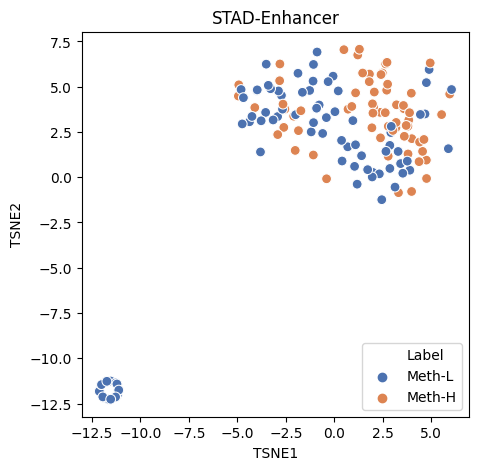

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

Region = 'Enhancer'
region_dic = {'CGI':3,'Non CGI':4, 'Promoter':5, 'Non promoter':6, 'Enhancer':7}
num = region_dic[Region]
#FEATURES = [f'{LOC}/{CANCER}/{CANCER}_EXP.csv', f'{LOC}/{CANCER}/{CANCER}_CNV.csv',
#f'{LOC}/{CANCER}/{CANCER}_MUT.csv', f'{LOC}/{CANCER}/{CANCER}_cpgisland.csv', f'{LOC}/{CANCER}/{CANCER}_non_cpgisland.csv',
#f'{LOC}/{CANCER}/{CANCER}_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_non_promoter.csv', f'{LOC}/{CANCER}/{CANCER}_enhancer.csv']

#cpgisland =3
#non cpgisland = 4
#promoter = 5
#non promoter = 6
#enhancer = 7
# Assuming your data frame contains numeric values only, you can use the following line to convert it to a numpy array
X = feats[num].values

# Perform t-SNE with n_components=2 (to visualize in 2D) and random_state for reproducibility
tsne = TSNE(n_components=2, random_state=0)
X_embedded = tsne.fit_transform(X)

# Add the labels to the t-SNE embedded data
df_tsne = pd.DataFrame(X_embedded, columns=['TSNE1', 'TSNE2'])
df_tsne.index = feats[5].index
#df_tsne.index = pam50.index
df_tsne['Label'] = result_df_f['Label']

# Plot using seaborn or matplotlib (replace 'Label' with the actual column name in your labels file)
plt.figure(figsize=(5, 5))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=df_tsne, palette='deep', s=50)
plt.title(CANCER+'-'+Region)
plt.legend(loc='lower right')
plt.savefig(CANCER+Region+'.pdf')
plt.show()


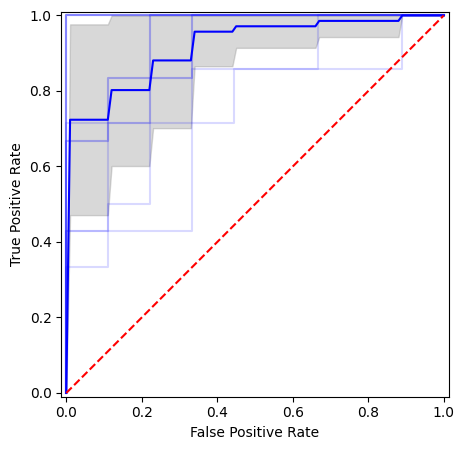

AUC scores: [0.7301587301587302, 0.8095238095238095, 1.0, 0.9365079365079365, 1.0, 0.925925925925926, 0.8703703703703705, 0.9259259259259259, 1.0, 1.0]
Mean AUC: 0.9198412698412699
Mean AUC 95% Confidence Interval: (0.85, 0.99)


In [ ]:
result_df_f['Label'] = result_df_f['Sum'].apply(lambda x: 1 if x > median_value else 0)

df_meth = feats[num].reindex(result_df_f.index)
df_all = pd.concat([df_meth,result_df_f.Label],axis=1)
df_all
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from scipy import stats


# Separate features and labels
X = df_all.drop(columns=['Label'])
y = np.array(df_all['Label'])

# Standardize features
column_transformer = ColumnTransformer([('scaler', StandardScaler(), X.columns)])
X_scaled = column_transformer.fit_transform(X)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Set hyperparameters
input_size = X_scaled.shape[1]
hidden_size = 64
num_classes = len(np.unique(y))

# Initialize the model
model = MLP(input_size, hidden_size, num_classes)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate AUC using cross-validation
auc_scores = []
tprs = []
base_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(5, 5))
plt.axes().set_aspect('equal', 'datalim')

for train_index, test_index in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    
    # Train the model
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_probs = test_outputs[:, 1].numpy()  # Assuming binary classification
        auc_score = roc_auc_score(y_test, test_probs)  # Renamed the variable to auc_score
        auc_scores.append(auc_score)
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, test_probs)
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, 'b', alpha=0.15)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b')
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('Test.pdf')
plt.show()

# Print the AUC scores
print("AUC scores:", auc_scores)
mean_auc = np.mean(auc_scores)
confidence = 0.95
confidence_interval = stats.sem(auc_scores) * stats.t.ppf((1 + confidence) / 2, len(auc_scores) - 1)

# Print the mean AUC and its confidence interval
print("Mean AUC:", mean_auc)
print(f"Mean AUC 95% Confidence Interval: ({mean_auc - confidence_interval:.2f}, {mean_auc + confidence_interval:.2f})")



In [14]:
 # old_cols are gene names
old_cols = feats[0].columns.values
    # old rows are patient names    
old_rows = feats[0].index.values
    # new_cols are ids 0:n.genes
new_cols = pd.factorize(old_cols)[0]
    # new_rows are ids 0:n.patients
new_rows = pd.factorize(old_rows)[0]

    # Mapping between genes and ids 
col_pairs = {name: no for name,no in zip(old_cols, new_cols)}
    # Mapping between patient names and ids
row_pairs = {name: no for name,no in zip(old_rows, new_rows)}

    # Harmonize/Reduce PPI with feature matrix
ppi = ppi[ppi[ppi.columns.values[0]].isin(old_cols)]
ppi = ppi[ppi[ppi.columns.values[1]].isin(old_cols)]

    #print(ppi)
    # convert genes to node ids
ppi[ppi.columns.values[0]] = ppi[ppi.columns.values[0]].map(col_pairs)
ppi[ppi.columns.values[1]] = ppi[ppi.columns.values[1]].map(col_pairs)    

    # col_pairs --> node ids + gene names!


edge_index = ppi[[ppi.columns.values[0], ppi.columns.values[1]]].to_numpy()
    #print(edge_index)
    # convert to a proper format and sort
edge_index = np.array(sorted(edge_index, key = lambda x: (x[0], x[1]))).T

col_pairs
gene_pairs ={value: key for key, value in col_pairs.items()}
gene_pairs

{0: 'FKBP5',
 1: 'TRAF1',
 2: 'TNFAIP8',
 3: 'TSPAN32',
 4: 'PLGRKT',
 5: 'STOM',
 6: 'SUSD3',
 7: 'IFITM2',
 8: 'SLC31A2',
 9: 'TRIM21',
 10: 'ADAM28',
 11: 'CD274',
 12: 'NEK6',
 13: 'ARL4C',
 14: 'SP110',
 15: 'TRIM22',
 16: 'ITK',
 17: 'CREM',
 18: 'GCNT1',
 19: 'DDX58',
 20: 'PHF11',
 21: 'SIGLEC14',
 22: 'IFITM3',
 23: 'SIRPB1',
 24: 'HAVCR2',
 25: 'AKIRIN2',
 26: 'HLA-DRB5',
 27: 'ACTB',
 28: 'IFNB1',
 29: 'PDCD1LG2',
 30: 'CTSL',
 31: 'SPAG6',
 32: 'SP100',
 33: 'PPP1R18',
 34: 'IFITM1',
 35: 'PML',
 36: 'ST6GALNAC6',
 37: 'GSN',
 38: 'STXBP1',
 39: 'NCS1',
 40: 'RGS16',
 41: 'ANXA2',
 42: 'AHNAK',
 43: 'LIX1L',
 44: 'XCL1',
 45: 'MSANTD3',
 46: 'ROR2',
 47: 'EVC2',
 48: 'C10orf55',
 49: 'S1PR3',
 50: 'LSM1',
 51: 'HHEX',
 52: 'GAS1',
 53: 'BAG4',
 54: 'SH3PXD2A',
 55: 'CUEDC1',
 56: 'DDHD2',
 57: 'IGF2BP3',
 58: 'EXT1',
 59: 'CNTLN',
 60: 'SMIM3',
 61: 'CDKN2A',
 62: 'SOX9',
 63: 'NFIL3',
 64: 'FOXE1',
 65: 'LPIN2',
 66: 'CXXC5',
 67: 'SLC25A25',
 68: 'PHF19',
 69: 'ENAH',
 70

In [11]:
###Convert feature dataframes with vector 
def flatten_list_iterative(lst):
    flattened_list = []
    stack = [lst]
    while stack:
        item = stack.pop()
        if isinstance(item, list):
            stack.extend(item)
        else:
            flattened_list.append(item)
    return flattened_list[::-1]

def flatten_array(arr):
    lst = arr.tolist()  # Convert the NumPy array to a list
    return flatten_list_iterative(lst) 

In [9]:
#Create cancer_graph_object

def cancer_graph_list(feats, node_feature_num, sample_size, node_number):
    new_temp = []
    feat_stack = np.stack(feats, axis=-1)
    empty_array = np.empty((sample_size, node_number, node_feature_num))
    for i in range(sample_size):
        for j in range(node_number):
            flattened_list = flatten_array(feat_stack[i, j, :])
            if len(flattened_list) == node_feature_num:
                empty_array[i, j, :] = flattened_list
            else:
                if len(flattened_list) > node_feature_num:
                    flattened_list = flattened_list[:node_feature_num] 
                else:
                    flattened_list += [0] * (node_feature_num - len(flattened_list))  # Pad the list with zeros
                    empty_array[i, j, :] = flattened_list

    for item in empty_array:
        new_temp.append(item)
        temp = np.array(new_temp)
    return temp

In [12]:
ae_space_dim = 1
node_feature_num = 3 + (len(feats)-3)*ae_space_dim
sample_size = len(feats[0])
node_number = len(feats[0].columns)
feats = feats

graph = cancer_graph_list(feats, node_feature_num, sample_size, node_number)
graph.shape

(404, 616, 8)

In [15]:
graphs = []
Label = Stem
for idx in range(graph.shape[0]):
    if np.isnan(graph[idx]).any() or np.isnan(Label[idx]):
        continue  # Skip data instances with NaN values
    graphs.append(Data(x=torch.tensor(graph[idx]).float(),
                       edge_index=torch.tensor(edge_index, dtype=torch.long),
                       y=torch.tensor(Label[idx], dtype=torch.long).unsqueeze(0)))           
graphs

[Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], y=[1]),
 Data(x=[616, 8], edge_index=[2, 4914], 

In [ ]:
def visualize_graph(graph, gene_pairs):
    vis = to_networkx(graph)
    plt.figure(1, figsize=(15, 15))
    nx.draw(vis,pos = nx.circular_layout(vis), cmap=plt.get_cmap('Set3'),node_color = '#C6442A',node_size=80, linewidths=13, labels = gene_pairs)
    plt.show()

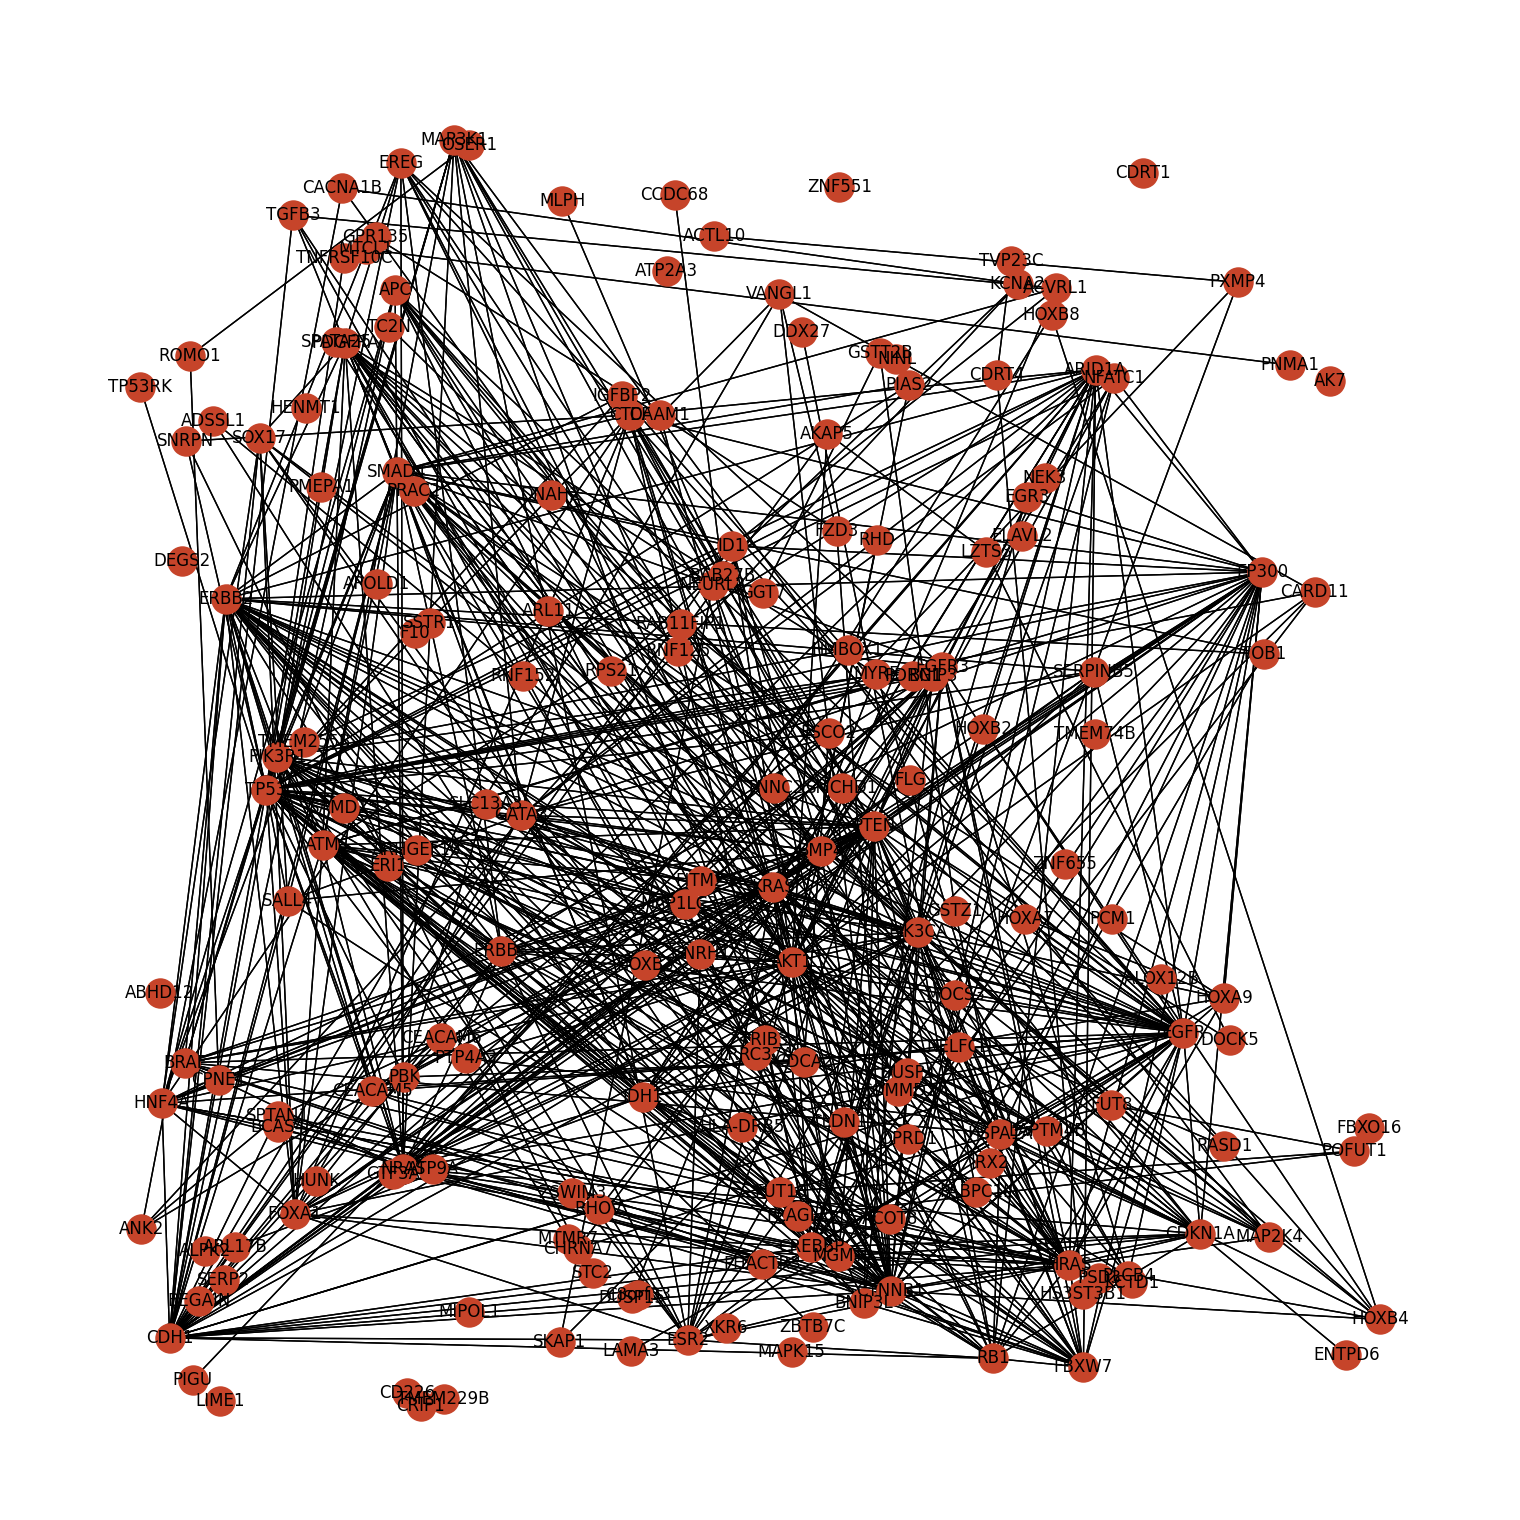

In [ ]:
visualize_graph(graphs[0], gene_pairs)

In [94]:
G = graphs[0]
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')
g = pyg_utils.to_networkx(G, to_undirected = True)
node_degrees = dict(nx.degree(g))
highest_degree_gene = [node for node, degree in node_degrees.items() if degree == max(node_degrees.values())]
print(highest_degree_gene)
gene_pairs[highest_degree_gene[0]]

Number of nodes: 215
Number of edges: 3926
Average node degree: 18.26
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True
[152]


'TP53'

In [48]:
g.degree

DegreeView({'x': 1, tensor([[ 6.1315,  0.0000,  0.0000,  ...,  0.1400,  0.0088,  0.0876],
        [ 4.6871, -1.0000,  0.0000,  ...,  0.1331,  0.0145,  0.1039],
        [ 5.2524, -1.0000,  0.0000,  ...,  0.1328,  0.0194,  0.0987],
        ...,
        [ 3.2800,  0.0000,  0.0000,  ...,  0.1466,  0.0159,  0.1174],
        [ 7.2069,  0.0000,  0.0000,  ...,  0.1383,  0.0103,  0.1174],
        [ 5.4165,  1.0000,  0.0000,  ...,  0.1421,  0.0263,  0.1174]]): 1, 'edge_index': 1, tensor([[  0,   0,   0,  ..., 615, 615, 615],
        [ 27,  70, 102,  ..., 533, 593, 612]]): 1, 'y': 1, tensor([0]): 1})

In [280]:
#Only for individual feature, can skip
import copy

# Create the graph lists
graph_exp = copy.deepcopy(graphs)  # Create a deep copy of the original graph list
graph_cnv = copy.deepcopy(graphs)
graph_mut = copy.deepcopy(graphs)

# Modify the `x` attribute for each graph list
for data in graph_exp:
    data.x = data.x[:, 0]
    data.x = data.x.view(-1, 1)  # Keep only the first column

for data in graph_cnv:
    data.x = data.x[:, 1]  # Keep only the second column
    data.x = data.x.view(-1, 1)  # Keep only the first column

for data in graph_mut:
    data.x = data.x[:, 2]  # Keep only the third column
    data.x = data.x.view(-1, 1)  # Keep only the first column

In [229]:
def plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name):
    """
        Note: It would be easy to do various kinds of powerful network analysis using igraph/networkx, etc.
        I chose to explicitly calculate only the node degree statistics here, but you can go much further if needed and
        calculate the graph diameter, number of triangles and many other concepts from the network analysis field.

    """
    if isinstance(edge_index, torch.Tensor):
        edge_index = edge_index.cpu().numpy()
        
    assert isinstance(edge_index, np.ndarray), f'Expected NumPy array got {type(edge_index)}.'

    # Store each node's input and output degree (they're the same for undirected graphs such as Cora/PPI)
    in_degrees = np.zeros(num_of_nodes, dtype=np.int)
    out_degrees = np.zeros(num_of_nodes, dtype=np.int)

    # Edge index shape = (2, E), the first row contains the source nodes, the second one target/sink nodes
    # Note on terminology: source nodes point to target/sink nodes
    num_of_edges = edge_index.shape[1]
    for cnt in range(num_of_edges):
        source_node_id = edge_index[0, cnt]
        target_node_id = edge_index[1, cnt]

        out_degrees[source_node_id] += 1  # source node points towards some other node -> increment it's out degree
        in_degrees[target_node_id] += 1  # similarly here

    hist = np.zeros(np.max(out_degrees) + 1)
    for out_degree in out_degrees:
        hist[out_degree] += 1

    fig = plt.figure(figsize=(12,8), dpi=100)  # otherwise plots are really small in Jupyter Notebook
    fig.subplots_adjust(hspace=0.6)

    plt.subplot(311)
    plt.plot(in_degrees, color='red')
    plt.xlabel('node id'); plt.ylabel('in-degree count'); plt.title('Input degree for different node ids')

    plt.subplot(312)
    plt.plot(out_degrees, color='green')
    plt.xlabel('node id'); plt.ylabel('out-degree count'); plt.title('Out degree for different node ids')

    plt.subplot(313)
    plt.plot(hist, color='blue')
    plt.xlabel('node degree'); plt.ylabel('# nodes for a given out-degree'); plt.title(f'Node out-degree distribution for {dataset_name} dataset')
    plt.xticks(np.arange(0, len(hist), 20.0))

    plt.grid(True)
    plt.show()

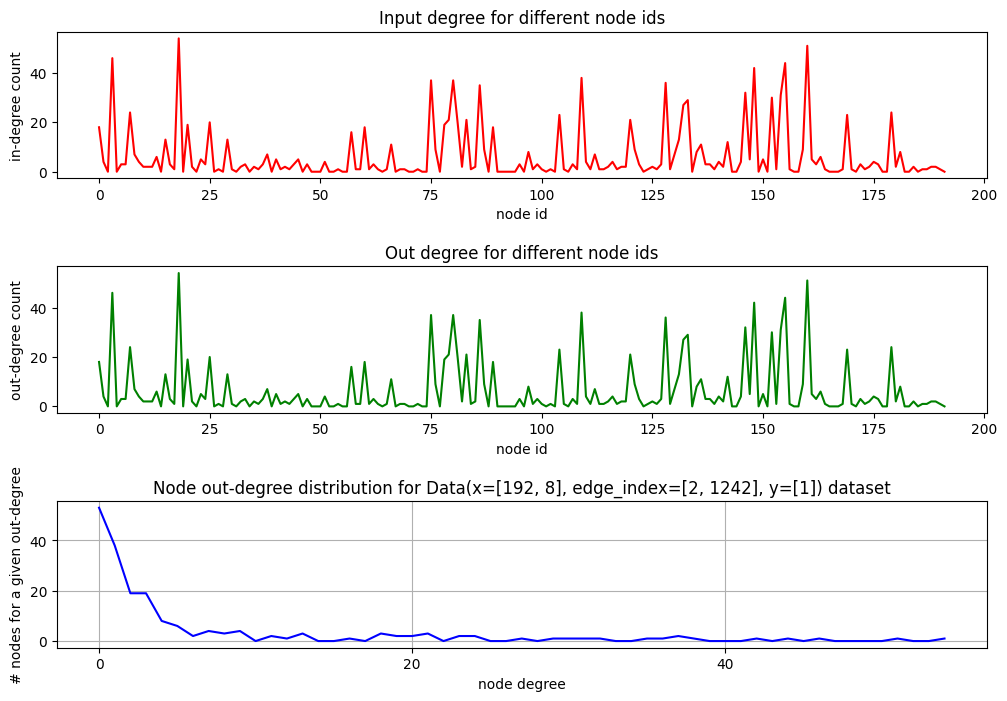

In [230]:
edge_index = graphs[0].edge_index
num_of_nodes = 192
dataset_name = graphs[0]
plot_in_out_degree_distributions(edge_index, num_of_nodes, dataset_name)

In [16]:
from torch_geometric.data import Dataset, Data


class graph2dataset(Dataset):
    def __init__(self, graph_list):
        super(graph2dataset, self).__init__()
        self.graph_list = graph_list

    def __len__(self):
        return len(self.graph_list)

    def __getitem__(self, index):
        if isinstance(index, int):
            # Single index access
            graph_data = self.graph_list[index]
        elif isinstance(index, slice):
            # Slice indexing
            graph_data = self.graph_list[index.start:index.stop:index.step]
        else:
            raise IndexError("Invalid index type. Only integers or slices are supported.")

        if isinstance(graph_data, list):
            # If the sliced result is a list, create a new CustomGraphDataset
            return graph2dataset(graph_data)
        
        # Assuming the graph_data is in a format with attributes 'x' (node features) and 'edge_index' (edge connectivity)
        x = graph_data.x
        edge_index = graph_data.edge_index
        y = graph_data.y

        # Create a PyTorch Geometric Data object
        data = Data(x=x, edge_index=edge_index, y=y)

        return data

In [378]:
###panGIN
from torch_geometric.nn import GINConv
from torch.nn import Linear
from torch.nn import BCEWithLogitsLoss

batch_size = 128
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 64

class panGIN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(panGIN, self).__init__()
        torch.manual_seed(000)
        self.convs = nn.ModuleList()
        self.convs.append(GINConv(Linear(input_dim, hidden_dim)))
        for i in range(2):
            self.convs.append(GINConv(Linear(hidden_dim, hidden_dim)))

        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = 0.25
        self.num_layers = 3

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)
        x = pyg_nn.global_mean_pool(x, batch)
        x = self.post_mp(x)

        return F.log_softmax(x)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)
        # BCEWithLogitsLoss()(pred, label)


def train(dataset, writer):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)

    # build model
    model = panGIN(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

   # train
    for epoch in range(100):
        total_loss = 0
        total_correct = 0  # variable to keep track of correct predictions
        total_samples = 0  # variable to keep track of total samples
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs

            # Calculate the number of correct predictions
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs

        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples  # Calculate the training accuracy

        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)  # Add train accuracy to writer

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        correct += pred.eq(label).sum().item()

    total = len(loader.dataset)
    return correct / total

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gin = graph2dataset(graphs)
model = train(dataset_gin, writer)


/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0. Loss: 0.8690. Train accuracy: 0.6000. Test accuracy: 0.5714
Epoch 10. Loss: 0.6979. Train accuracy: 0.5897. Test accuracy: 0.5714
Epoch 20. Loss: 0.6487. Train accuracy: 0.5949. Test accuracy: 0.5714


KeyboardInterrupt: 

In [266]:
###panSAGE
from torch_geometric.nn import SAGEConv

batch_size = 128
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 64

class panGraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(panGraphSAGE, self).__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(input_dim, hidden_dim, normalize=True))
        for i in range(3):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim, normalize=True))

        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))

        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.6), 
            nn.Linear(hidden_dim, output_dim))
    
        self.dropout = 0.6
        self.num_layers = 4
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
          
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)
        
        x = pyg_nn.global_mean_pool(x, batch)
        x = self.post_mp(x)

        return F.log_softmax(x)
        
    def loss(self, pred, label):
        return F.nll_loss(pred, label)

def train(dataset, writer):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.7)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.7):], batch_size=batch_size, shuffle=True)

    # build model
    model = panGraphSAGE(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # train
    for epoch in range(200):
        total_loss = 0
        total_correct = 0  # variable to keep track of correct predictions
        total_samples = 0  # variable to keep track of total samples
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs

            # Calculate the number of correct predictions
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs

        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples  # Calculate the training accuracy

        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)  # Add train accuracy to writer

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
            
        correct += pred.eq(label).sum().item()
    
    total = len(loader.dataset) 
    return correct / total

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_sage = graph2dataset(graphs)
model = train(dataset_sage, writer)

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0. Loss: 0.6849. Train accuracy: 0.5244. Test accuracy: 0.5211
Epoch 10. Loss: 0.6788. Train accuracy: 0.5854. Test accuracy: 0.5211
Epoch 20. Loss: 0.6707. Train accuracy: 0.5915. Test accuracy: 0.5211
Epoch 30. Loss: 0.6693. Train accuracy: 0.5854. Test accuracy: 0.5211
Epoch 40. Loss: 0.6708. Train accuracy: 0.5732. Test accuracy: 0.5634
Epoch 50. Loss: 0.6718. Train accuracy: 0.5854. Test accuracy: 0.5915
Epoch 60. Loss: 0.6898. Train accuracy: 0.5854. Test accuracy: 0.5775
Epoch 70. Loss: 0.6634. Train accuracy: 0.6159. Test accuracy: 0.5915
Epoch 80. Loss: 0.6490. Train accuracy: 0.6280. Test accuracy: 0.5352
Epoch 90. Loss: 0.6180. Train accuracy: 0.6829. Test accuracy: 0.5493
Epoch 100. Loss: 0.6098. Train accuracy: 0.6829. Test accuracy: 0.5634
Epoch 110. Loss: 0.5796. Train accuracy: 0.7012. Test accuracy: 0.5352
Epoch 120. Loss: 0.5852. Train accuracy: 0.7012. Test accuracy: 0.5070
Epoch 130. Loss: 0.6127. Train accuracy: 0.6768. Test accuracy: 0.5352
Epoch 140. Loss: 

In [265]:
###panGAT without pooling
###We have to use graph pooling instead of scatter mean 
from torch_geometric.nn import GATConv
from torch_geometric.nn.dense import Linear
import torch_scatter

class panGAT(nn.Module):
      def __init__(self, input_dim, hidden_dim, output_dim):
            super(panGAT, self).__init__()
            self.heads = 8
            self.conv1 = GATConv(input_dim, hidden_dim, heads = self.heads, dropout = 0.6)
            self.conv2 = GATConv(hidden_dim*self.heads, output_dim, heads = 1, concat = True, dropout = 0.6)
      
      def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch_scatter.scatter(x, batch, dim=0, reduce='mean')
        #x = torch_scatter.scatter_mean(x, batch, dim=0)
        return F.log_softmax(x, dim=1)
        
      def loss(self, pred, label):
        return F.nll_loss(pred, label)

def train(dataset, writer):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)

    # build model
    model = panGAT(max(dataset.num_node_features, 1), 8, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # train
    for epoch in range(500):
        total_loss = 0
        total_correct = 0  # variable to keep track of correct predictions
        total_samples = 0  # variable to keep track of total samples
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs

            # Calculate the number of correct predictions
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs

        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples  # Calculate the training accuracy

        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)  # Add train accuracy to writer

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

    
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    total = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y
            correct += pred.eq(label).sum().item()
            total += len(label)
    
    return correct / total


writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
#dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset_gat = graph2dataset(graphs)
model = train(dataset_gat, writer)



Epoch 0. Loss: 0.6832. Train accuracy: 0.5851. Test accuracy: 0.4894
Epoch 10. Loss: 0.6584. Train accuracy: 0.6383. Test accuracy: 0.5106
Epoch 20. Loss: 0.6446. Train accuracy: 0.6011. Test accuracy: 0.4894
Epoch 30. Loss: 0.6398. Train accuracy: 0.6011. Test accuracy: 0.4894
Epoch 40. Loss: 0.6366. Train accuracy: 0.6170. Test accuracy: 0.5106
Epoch 50. Loss: 0.6209. Train accuracy: 0.6649. Test accuracy: 0.4681
Epoch 60. Loss: 0.6313. Train accuracy: 0.6117. Test accuracy: 0.5106
Epoch 70. Loss: 0.6146. Train accuracy: 0.7021. Test accuracy: 0.5106
Epoch 80. Loss: 0.6361. Train accuracy: 0.6489. Test accuracy: 0.5106
Epoch 90. Loss: 0.6183. Train accuracy: 0.6649. Test accuracy: 0.5106
Epoch 100. Loss: 0.6247. Train accuracy: 0.6489. Test accuracy: 0.5106
Epoch 110. Loss: 0.6343. Train accuracy: 0.6489. Test accuracy: 0.4894
Epoch 120. Loss: 0.6398. Train accuracy: 0.6277. Test accuracy: 0.5106
Epoch 130. Loss: 0.6298. Train accuracy: 0.6596. Test accuracy: 0.5319
Epoch 140. Loss: 

KeyboardInterrupt: 

In [20]:
###panGCN: for graph pooling
from torch_geometric.nn import GraphConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

batch_size = 256
lr = 5e-4
weight_decay = 1e-4
hidden_dim = 128
        
class panGCN(nn.Module):
      def __init__(self, input_dim, hidden_dim, output_dim):
            super(panGCN, self).__init__()
            self.ratio = 0.6
            self.conv1 = GraphConv(input_dim, hidden_dim)
            self.pool1 = TopKPooling(hidden_dim, ratio = self.ratio) 
            self.conv2 = GraphConv(hidden_dim, hidden_dim)
            self.pool2 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv3 = GraphConv(hidden_dim, hidden_dim)
            self.pool3 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.conv4 = GraphConv(hidden_dim, hidden_dim)
            self.pool4 = TopKPooling(hidden_dim, ratio = self.ratio)
            self.lin1 = torch.nn.Linear(hidden_dim*2, hidden_dim)   
            self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim//2)
            self.lin3 = torch.nn.Linear(hidden_dim//2, output_dim)  
      
      def forward(self, x, edge_index, batch):
          x = F.relu(self.conv1(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
          x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv2(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
          x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = F.relu(self.conv3(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
          x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)
          x = F.relu(self.conv4(x, edge_index))
          x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
          x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

          x = x1 + x2 + x3 + x4

          x = F.relu(self.lin1(x))
          x = F.dropout(x, p=0.7, training=self.training)
          x = F.relu(self.lin2(x))
          x = F.log_softmax(self.lin3(x), dim=-1)

          return x
        

def train(dataset, writer, patience=10):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)
    
    # build model
    model = panGCN(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    best_test_acc = 0.0  # Keep track of the best test accuracy
    early_stopping_counter = 0  # Counter for early stopping
    
    for epoch in range(500):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        model.train()
        
        for batch in loader:
            opt.zero_grad()
            pred = model(batch.x, batch.edge_index, batch.batch)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
            
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
        
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)
        
        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
            
            writer.add_scalar("test accuracy", test_acc, epoch)
            
            if test_acc > best_test_acc:
                best_test_acc = test_acc
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1
                
            if early_stopping_counter >= patience:
                print("Early stopping at epoch", epoch)
                break  # Stop training
                
    return model
      
def test(loader, model):
    model.eval()
    correct = 0.
    loss = 0.  
    for batch in loader:
        out  = model(batch.x, batch.edge_index, batch.batch)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y,reduction='sum').item()
        
    return correct *1.0 / len(loader.dataset)

writer = SummaryWriter(f"{LOC}/log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gcn = graph2dataset(graphs)
torch.manual_seed(0000)
model = train(dataset_gcn, writer)
# Flush and close the writer
writer.flush()
writer.close()

Epoch 0. Loss: 8760.6584. Train accuracy: 0.4953. Test accuracy: 0.4198


KeyboardInterrupt: 

In [114]:
###This chunk is created for graph prediction, extracted from Github examples
from torch_geometric.nn import MessagePassing
# Solution

def graph_loss(
    x: torch.tensor,                     
    edge_index: torch.tensor,
    batch_index: torch.tensor,
    node_feat_mask: torch.nn.Parameter, 
    edge_mask: torch.nn.Parameter,      
    expl_label: int,
    model) -> torch.tensor:
    """
    Computes the explainer loss function for explanation
    of graph classificaiton tasks.

    Args:
        x : torch.Tensor
            Feature matrix of datapoint to explain.
        edge_index : torch.LongTensor
            A Tensor that defines the underlying graph connectivity/message
            passing flow. `edge_index` holds the indices of a general (sparse)
            assignment matrix of shape `[N, M]`. Its shape must be defined as
            `[2, num_messages]`, where messages from nodes in `edge_index[0]`
            are sent to nodes in `edge_index[1]`.
        batch_index : torch.LongTensor
            Column vector which maps each node to its respective graph in the batch.
        node_feat_mask : torch.nn.Parameter
            representing node feature mask of size [n_features]
        edge_mask : torch.nn.Parameter
            representing edge mask of size [n_edges]
        expl_label : int
            Label with respect to which we want the explanation.
        model : nn.Module
            a (pretrained) model
    Returns:
        loss (torch.tensor): explainer loss function, which
            is a weight sum of different terms.
    """
    EPS = 1e-15

    # Apply sigmoid to masks
    edge_mask = edge_mask.sigmoid()
    node_feat_mask = node_feat_mask.sigmoid()

    # Loss terms weights
    coeffs = {"edge_size":0.01,
            "node_feat_size":0.07,
            "edge_entropy":1.0}

    # Mask node features
    h = x * node_feat_mask

    # Mask edges: instead of applying the mask on edge_index, make the model
    # aware of the mask
    for module in model.modules():
        if isinstance(module, MessagePassing):
            module.__explain__ = True
            module.__edge_mask__ = edge_mask

    # Compute model output (we assume the model already gives log probabilities)
    model_pred_log_proba = model(h, edge_index, batch_index)

    # Prediction loss.
    pred_loss = -model_pred_log_proba[:, expl_label]

    # Edge mask size loss.
    edge_mask_size_loss = edge_mask.sum()

    # Edge mask entropy loss.
    ent_loss = (-edge_mask * torch.log(edge_mask + EPS) -
                (1 - edge_mask) * torch.log(1 - edge_mask + EPS)).mean()

    # Feature mask size loss.
    feat_mask_size_loss = node_feat_mask.sum()

    # Sum all loss terms
    loss = pred_loss + \
           coeffs['edge_size'] * edge_mask_size_loss + \
           coeffs['edge_entropy'] *ent_loss + \
           coeffs['node_feat_size'] * feat_mask_size_loss

    return loss.sum()

In [21]:
###This chunk is created for graph prediction, extracted from Github examples

import math
from copy import deepcopy

dataset = dataset_gcn1
data_size = len(dataset)
loader = DataLoader(dataset, batch_size=32,shuffle=True)

data_batch = next(iter(loader))

x = data_batch.x
edge_index = data_batch.edge_index
batch_index = data_batch.batch

(nodes, feat), edges = x.size(), edge_index.size(1)

# Feat mask
node_feat_mask = torch.nn.Parameter(torch.randn(feat) * 0.1)

# Edge mask.
edge_mask = torch.nn.Parameter(torch.randn(edges) * 0.1)

expl_label = 1

loss = graph_loss(x,                     
    edge_index,
    batch_index,
    node_feat_mask, 
    edge_mask,      
    expl_label,
    deepcopy(model))

print(f"Computed loss : {round(loss.item(), 2)}")

NameError: name 'dataset_gcn1' is not defined

In [116]:
data_batch

DataBatch(x=[6880, 8], edge_index=[2, 125632], y=[32], batch=[6880], ptr=[33])

In [105]:
###This chunk is created for graph prediction, extracted from Github examples
from src import GNNExplainer
from src import plot_mol
from src import make_interactive_explainer, explain_graph_visualized

In [421]:
#For symbol labeling
gene_symbols = []
for keys, values in gene_pairs.items():
    gene_symbols.append(values)
gene_symbols = pd.Series(data = gene_symbols)

class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __init__(self, gene_symbols):
        self.gene_symbols = gene_symbols

    def __call__(self, data):
        data.symbols = self.gene_symbols
        return data

dataset = dataset_gcn
transform = AddSymbols(gene_symbols.values)
dataset_t = [transform(data) for data in dataset]


In [117]:
###This chunk is created for graph prediction, extracted from Github examples

feat_mask_temp = np.zeros(8)
edge_mask_temp = np.zeros(3926)

#Compute cumulative node and edge importance througout dataset
for data in dataset_gcn:
    torch.manual_seed(1234)
    explainer = GNNExplainer(model, epochs=200, lr = 0.01)
    # Train explainer
    model_args = (
    data.x,
    data.edge_index,
    torch.zeros(data.num_nodes, dtype=int))
    
    GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
    *model_args,
    model(*model_args).argmax(dim=1))

    # Convert the PyTorch tensors to numpy arrays
    feat_mask = GNNExp_feat_mask.detach().cpu().numpy()
    edge_mask = GNNExp_edge_mask.detach().cpu().numpy()
    

    feat_mask_temp+=feat_mask
    edge_mask_temp+=edge_mask


KeyboardInterrupt: 

In [118]:
data

Data(x=[215, 8], edge_index=[2, 3926], y=[1])

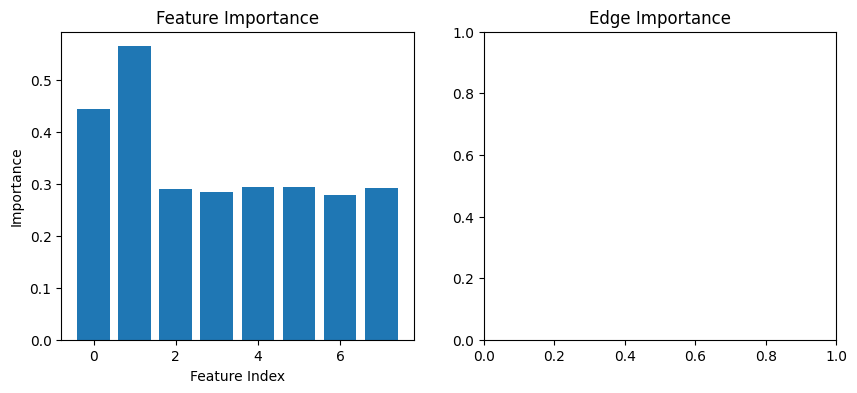

In [148]:
#Create plot only using matplotlib
import matplotlib.pyplot as plt
import networkx as nx

data = dataset_gcn[0]

feat_mask = feat_mask_temp/244
edge_mask = edge_mask_temp/244

# Visualize the feature mask
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Feature Importance")
plt.bar(range(len(feat_mask)), feat_mask)
plt.xlabel("Feature Index")
plt.ylabel("Importance")

# Visualize the edge mask
plt.subplot(1, 2, 2)
plt.title("Edge Importance")
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())
pos = nx.random_layout(G)

for i, (u, v) in enumerate(G.edges()):
    if edge_mask[i] > 0.45:  # Set a threshold for edge importance
        nx.draw(G, pos, edgelist=[(u, v)], with_labels=True,
        node_color='lightblue', width=edge_mask[i]*5, edge_color='red')
plt.show()

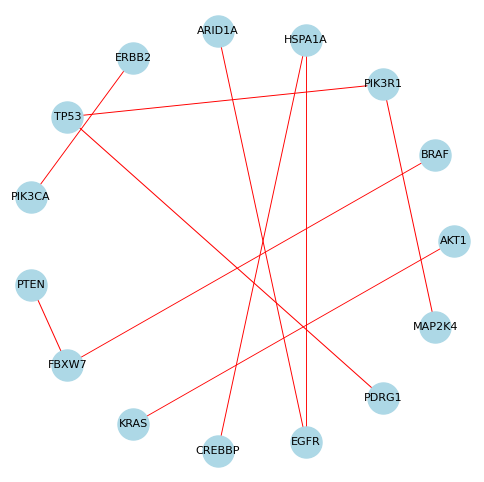

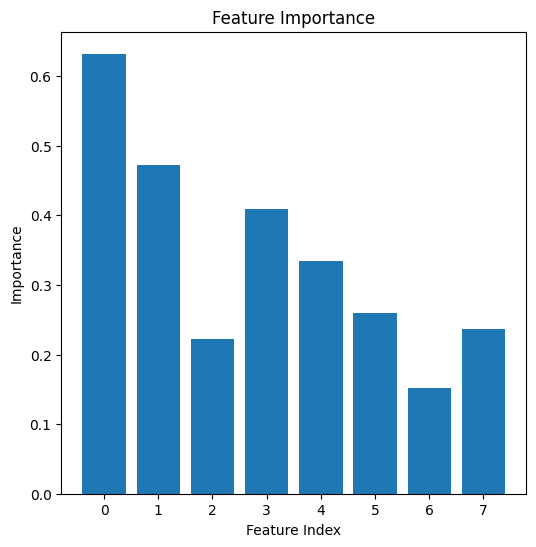

In [249]:
import matplotlib.pyplot as plt
import networkx as nx

feat_mask = feat_mask_temp/244
edge_mask = edge_mask_temp/244

sorted_edge = sorted(edge_mask, reverse=True)
top_ten_number = sorted_edge[:20]
threshold = top_ten_number[19]

# Create a new graph with only important nodes and edges
G = nx.Graph()
G.add_edges_from(data.edge_index.t().tolist())
important_edges = [(u, v) for i, (u, v) in enumerate(G.edges()) if edge_mask[i] >= threshold]
G = G.subgraph(list(set([u for u, v in important_edges] + [v for u, v in important_edges])))

# Define the gene pair labels dictionary
gene_labels = gene_pairs

# Map node labels using the gene pair labels dictionary
node_labels = {node: gene_labels.get(node, str(node)) for node in G.nodes()}

# Visualize the important nodes and edges
plt.figure(figsize=(6, 6))
pos = nx.circular_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=1)

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=important_edges, edge_color='red', width=[edge_mask[i]*5 for i in range(len(important_edges))])

# Draw labels
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black')

# Remove axis
plt.axis('off')

# Show the plot
plt.show()

# Visualize the feature mask
plt.figure(figsize=(6, 6))
plt.title("Feature Importance")
plt.bar(range(len(feat_mask)), feat_mask)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [159]:
#Load the Planetoid dataset
dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

In [170]:
import torch
from sklearn.cluster import KMeans

# Assuming your graph dataset is stored in a Data object
data = dataset_gcn[0]

# Get the node features from the data object
node_features = data.x

# Convert node features to a numpy array
node_features_np = node_features.numpy()

# Perform K-means clustering on the node features
num_clusters = 3  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters)
labels = kmeans.fit_predict(node_features_np)

# Assign the node labels to the data object
data.y = torch.from_numpy(labels)

# Print the assigned labels for the nodes
print(data.y)


tensor([0, 2, 2, 0, 1, 1, 2, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 2, 1, 0, 2,
        0, 0, 0, 1, 0, 2, 1, 2, 0, 0, 1, 1, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 2, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1, 0, 2,
        2, 0, 1, 0, 1, 1, 2, 2, 0, 2, 2, 2, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0,
        0, 0, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 2, 0, 2, 2, 2, 0, 2, 2, 1, 0, 0, 0,
        2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0,
        0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 0, 1, 0, 2, 2, 1, 1, 0,
        2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 1, 2, 2, 0, 2],
       dtype=torch.int32)


In [455]:
##Medium graph explain example

from torch_geometric.nn import GNNExplainer
explainer = GNNExplainer(model, epoch = 100, return_type='log_prob')
data = dataset_gcn[0]
node_feat_mask, edge_mask = explainer.explain_graph(data.x, data.edge_index, batch = data.batch)
ax, G = explainer.visualize_subgraph(-1, data.edge_index, edge_mask, data.y)
plt.show()

AssertionError: 

interactive(children=(Dropdown(description='which', options=('true_pos', 'true_neg', 'false_pos', 'false_neg')…

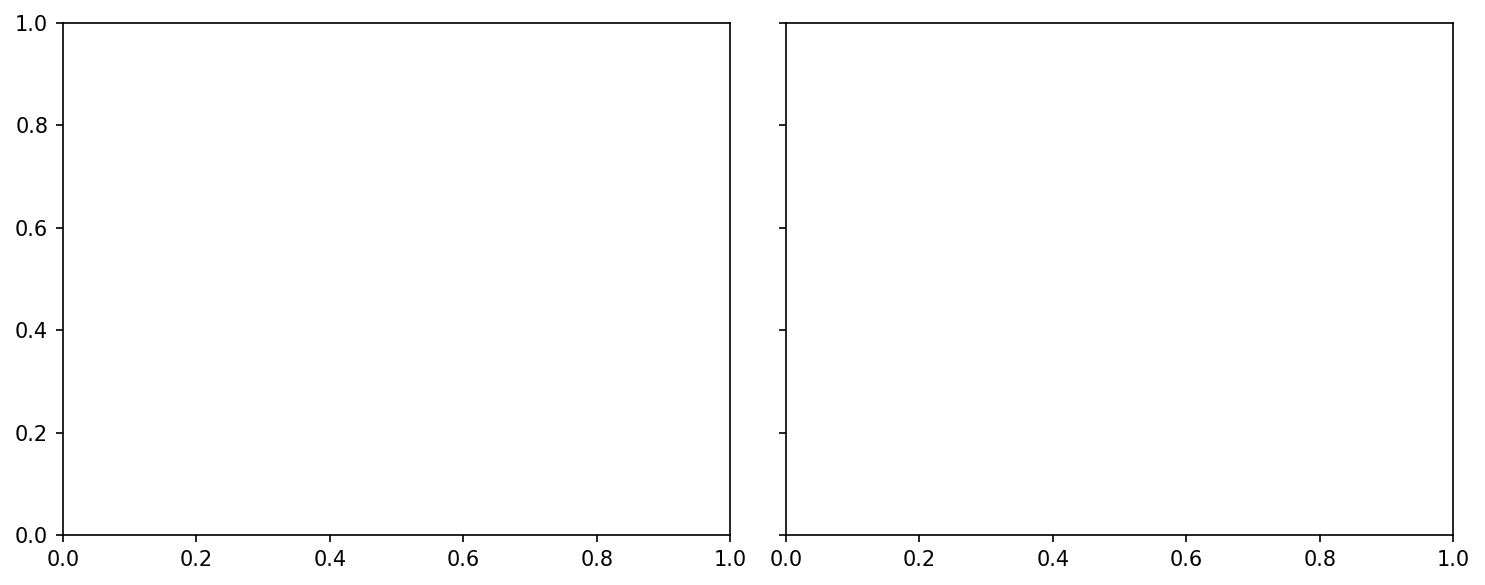

<function src.utility.make_interactive_explainer.<locals>.data_selector.<locals>.<lambda>(data)>

<function src.utility.make_interactive_explainer.<locals>.data_selector(which)>

In [269]:
# Assuming you have a constant edge attribute value of 1 for all edges:
device = "cuda" if torch.cuda.is_available() else "cpu"
data_list = []
for i in range(len(dataset_t)):
    num_edges = dataset_t[i].edge_index.size(1)
    edge_attr = torch.ones((num_edges, 1), dtype=torch.float) # Create edge attributes
    update_data = dataset_t[i]
    update_data.edge_attr = edge_attr
    data_list.append(update_data)


explainer_kwargs = dict(
    epochs=100,
    lr=0.04,
    edge_size=0.015,
    edge_ent=1.0,
    node_feat_size=0.7,
    node_feat_ent=0.1,
)

data_list = graph2dataset(data_list)


make_interactive_explainer(
    model, data_list,
    explainer_kwargs=explainer_kwargs,
    device=device
)

/Users/arthurdai/opt/anaconda3/lib/python3.7/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Accuracy: 67.50%


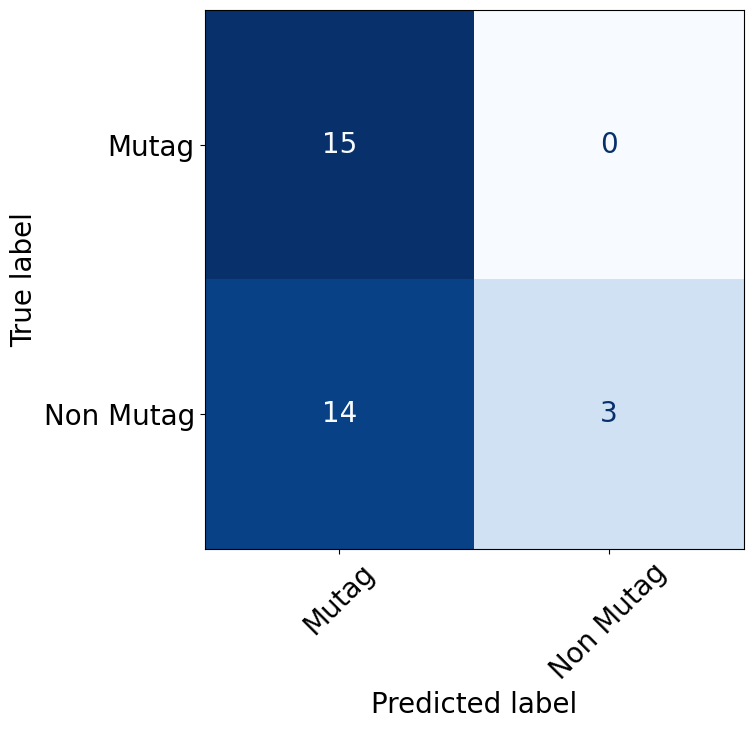

In [243]:
from src import compute_cm, plot_cm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from src import compute_accuracy

loader_test = DataLoader(data_list[80:200], batch_size=32, shuffle=False)

print(f"Accuracy: {compute_accuracy(model, loader_test):.2%}""")

# Compute cm
cm = compute_cm(model, loader_test)
# Plot cm
plot_cm(cm)

In [226]:
# Atom types, ordered accroding to one-hot-encoding
MUT_LABEL_ENC = pd.Series(data = ["C","O", "Cl","H","N","F","Br","S","P","I","Na","K","Li","Ca"])
print("Number of different elements: ", len(MUT_LABEL_ENC))

# Define transform
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph

# Load the dataset
dt = TUDataset(
    root=".", name="Mutagenicity",
    transform=AddSymbols(),
).shuffle()

dt[2].symbols.shape

Number of different elements:  14


(19,)

In [294]:
###panGAN 2: for graph pooling
from torch_geometric.nn import GATConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

batch_size = 128
lr = 0.001
weight_decay = 1e-4
hidden_dim = 64

class panGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(panGAT, self).__init__()
        self.ratio = 0.6
        self.heads = 3
        self.conv1 = GATConv(input_dim, hidden_dim, heads=self.heads, dropout=0.6)
        self.pool1 = TopKPooling(hidden_dim * self.heads, ratio=self.ratio)
        self.conv2 = GATConv(hidden_dim * self.heads, hidden_dim, heads=self.heads, dropout=0.6)
        self.pool2 = TopKPooling(hidden_dim * self.heads, ratio=self.ratio)
        self.conv3 = GATConv(hidden_dim * self.heads, hidden_dim, heads=self.heads, dropout=0.6)
        self.pool3 = TopKPooling(hidden_dim * self.heads, ratio=self.ratio)
        #self.conv4 = GATConv(hidden_dim * self.heads, hidden_dim, heads=8, dropout=0.6, concat = True)
        #self.pool4 = TopKPooling(hidden_dim * self.heads, ratio=self.ratio)

        self.lin1 = torch.nn.Linear(hidden_dim * self.heads *2, hidden_dim)
        self.lin2 = torch.nn.Linear(hidden_dim, hidden_dim // 2)
        self.lin3 = torch.nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.conv1(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.elu(self.conv2(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.elu(self.conv3(x, edge_index))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        #x = F.elu(self.conv4(x, edge_index))
        #x, edge_index, _, batch, _, _ = self.pool4(x, edge_index, None, batch)
        #x4 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        #x = x1 + x2 + x3 + x4
        x = x1 + x2 + x3 
        
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x
        

def train(dataset, writer):
    data_size = len(dataset)
    loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=batch_size, shuffle=True)
    # build model
    model = panGAT(max(dataset.num_node_features, 1), hidden_dim, dataset.num_classes)
    opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
   
    for epoch in range(100):
        total_loss = 0
        total_correct = 0  # variable to keep track of correct predictions
        total_samples = 0  # variable to keep track of total samples
        model.train()
        for batch in loader:
            opt.zero_grad()
            pred  = model(batch)
            label = batch.y
            loss = F.nll_loss(pred, label)
            loss.backward()
            total_loss += batch.num_graphs * loss.item()
            opt.step()
      # Calculate the number of correct predictions
            pred_labels = pred.argmax(dim=1)
            correct = pred_labels.eq(label).sum().item()
            total_correct += correct
            total_samples += batch.num_graphs
        total_loss /= len(loader.dataset)
        train_acc = total_correct / total_samples
    
        writer.add_scalar("loss", total_loss, epoch)
        writer.add_scalar("train accuracy", train_acc, epoch)  # Add train accuracy to writer
  

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Train accuracy: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, train_acc, test_acc))
        writer.add_scalar("test accuracy", test_acc, epoch)
        
    return model
      
def test(loader, model):
    model.eval()
    correct = 0.
    loss = 0.  
    for batch in loader:
        out  = model(batch)
        pred = out.argmax(dim=1)
        correct += pred.eq(batch.y).sum().item()
        loss += F.nll_loss(out, batch.y,reduction='sum').item()
        
    return correct *1.0 / len(loader.dataset)

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))
dataset_gat = graph2dataset(graphs)
model = train(dataset_gat, writer)

Epoch 0. Loss: 0.7025. Train accuracy: 0.3949. Test accuracy: 0.4286
Epoch 10. Loss: 0.6258. Train accuracy: 0.6154. Test accuracy: 0.6122
Epoch 20. Loss: 0.5889. Train accuracy: 0.7282. Test accuracy: 0.8163
Epoch 30. Loss: 0.5106. Train accuracy: 0.7692. Test accuracy: 0.7551
Epoch 40. Loss: 0.4767. Train accuracy: 0.7949. Test accuracy: 0.7347
Epoch 50. Loss: 0.4163. Train accuracy: 0.8000. Test accuracy: 0.7347
Epoch 60. Loss: 0.3882. Train accuracy: 0.8154. Test accuracy: 0.7347


KeyboardInterrupt: 

In [30]:
#From PyG, imported from torch_geometric.explain?
from torch_geometric.explain import Explainer, GNNExplainer

#Explain the Graph (YHD model)
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=100),
    explanation_type='model',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='raw',
    )
)
#node_index = 10
#explanation = explainer(data.x, data.edge_index, index=node_index)
graph_index = 0
data = dataset_gcn[graph_index]
explanation = explainer(data.x, data.edge_index, batch=data.batch)
print(f'Generated explanations in {explanation.available_explanations}')

#path = 'feature_importance.png'
#explanation.visualize_feature_importance(path, top_k=10)
#print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

from IPython.display import Image, display

# 顯示特徵重要性圖片
#display(Image('feature_importance.png'))

# 顯示子圖視覺化圖片
files.download('subgraph.pdf')

AssertionError: 